In [1]:
from matplotlib.ticker import FormatStrFormatter as fsf
import matplotlib.pyplot as plt
from plots.mpltoolkit import mpl_loc, named_colors, markers, fancy_legend, negative_log, load_style_sheet
# from plots.mpltoolkit import mpl_loc, named_colors, markers, fancy_legend, load_style_sheet
import numpy as np
import math as m
import vice
import sys
import os
sys.path.append("..")
from src.utils import mu, get_velocity_profile, boxcarsmoothtrend, oh_to_12pluslog
from src.plots.utils import weighted_median
from src.simulations.models.insideout import insideout
load_style_sheet("papers")
print(sys.version_info)

/Users/jamesjohnson/Work/Research/lib/public-dev/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)


In [2]:
# output = vice.output("../outputs/potential-well-deepening/gamma0p2")
output = vice.output("../outputs/constant/vgas-0")
extra = np.genfromtxt("%s_analogdata.out" % (output.name))
output.stars["absz"] = [abs(_) for _ in extra[:, -1][:output.stars.size[0]]]

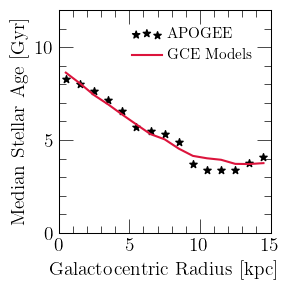

In [4]:
fig = plt.figure(figsize = (3, 3))
ax = fig.add_subplot(111)
ax.set_xlabel(r"Galactocentric Radius [kpc]")
ax.set_ylabel(r"Median Stellar Age [Gyr]")
ax.set_xlim([0, 15])
ax.set_ylim([0, 12])
ax.set_yticks([0, 5, 10])

def plot_data(ax, filename = "./apogee-astronn-ageprofile.out", **kwargs):
    raw = np.genfromtxt(filename)
    radii = [(a + b) / 2 for a, b in zip(raw[:, 0], raw[:, 1])]
    age = raw[:, 3]
    ax.scatter(radii, age, **kwargs)

def plot_prediction(ax, output, zone_width = 0.1, **kwargs):
    n_zones = len(output.zones.keys())
    # radii = [zone_width * (i + 0.5) for i in range(n_zones)]
    radii = list(range(16))
    ages = []
    for i in range(len(radii) - 1):
        # sys.stdout.write("\ri = %d
        inner = int(radii[i] / zone_width)
        outer = int(radii[i + 1] / zone_width) + 1
        stars = output.stars.filter(
            "zone_final", ">=", inner).filter(
            "zone_final", "<", outer).filter(
            "absz", "<=", 0.5).filter(
            "mass", ">", 1)
        ages.append(weighted_median(stars["age"], stars["mass"]))
    radii = [(a + b) / 2 for a, b in zip(radii[:-1], radii[1:])]
    ax.plot(radii, ages, **kwargs)

plot_data(ax, c = named_colors()["black"], marker = markers()["star"], s = 30, label = "APOGEE")
plot_prediction(ax, output, c = named_colors()["crimson"], label = "GCE Models")

kwargs = {
    "loc": mpl_loc("upper right"),
    "bbox_to_anchor": (0.98, 0.98),
    "fontsize": 11
}
leg = ax.legend(**kwargs)

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./evol/ageprofile.%s" % (ext), **kwargs)
plt.show()

/var/folders/26/nqb98q9x5_q6brmqy4v21dqm0000gp/T/ipykernel_60032/3018415466.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


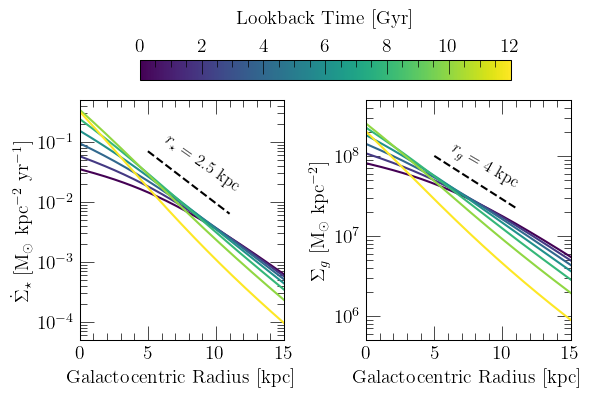

In [3]:
LOOKBACKS = [0, 2, 4, 6, 8, 10, 12]
COLORMAP = "viridis"

fig = plt.figure(figsize = (6, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
for ax in [ax1, ax2]:
    ax.set_yscale("log")
    ax.set_xlim([0, 15])
    ax.set_xlabel(r"Galactocentric Radius [kpc]")
ax1.set_ylabel(r"$\dot \Sigma_\star$ [M$_\odot$ kpc$^{-2}$ yr$^{-1}$]")
ax2.set_ylabel(r"$\Sigma_g$ [M$_\odot$ kpc$^{-2}$]")
ax1.set_ylim([5.e-5, 0.5])
ax2.set_ylim([5.e5, 5.e8])
# dummy = fig.add_axes([0.1, 0.1, 0.8, 0.8], xticks = [], yticks = [], zorder = -1000)
# dummy.spines["top"].set_visible(False)
# dummy.spines["bottom"].set_visible(False)
# dummy.set_xlabel(r"Galactocentric Radius [kpc]", labelpad = 20)

norm = plt.Normalize(vmin = min(LOOKBACKS), vmax = max(LOOKBACKS))
cmap = plt.cm.ScalarMappable(cmap = COLORMAP, norm = norm)
cbar_ax = fig.add_axes([0.2, 0.8, 0.6, 0.1])
cbar = plt.colorbar(cmap, cax = cbar_ax, orientation = "horizontal", location = "top")
cbar.set_label("Lookback Time [Gyr]", labelpad = 10)
cbar.set_ticks(LOOKBACKS)

def plot_snapshot(ax_sfh, ax_gas, output, lookback, zone_width = 0.1, **kwargs):
    radii = [zone_width * (i + 0.5) for i in range(len(output.zones.keys()))]
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    sigma_sfr = []
    sigma_gas = []
    for i in range(len(radii)):
        area = np.pi * ((radii[i] + zone_width / 2)**2 - (radii[i] - zone_width / 2)**2)
        zone = output.zones["zone%d" % (i)]
        sigma_sfr.append(zone.history["sfr"][idx] / area)
        sigma_gas.append(zone.history["mgas"][idx] / area)
    ax_sfh.plot(radii, sigma_sfr, **kwargs)
    ax_gas.plot(radii, sigma_gas, **kwargs)

for i in range(len(LOOKBACKS)):
    kwargs = {"c": cmap.to_rgba(LOOKBACKS[i])}
    plot_snapshot(ax1, ax2, output, LOOKBACKS[i], **kwargs)

kwargs = {
    "c": named_colors()["black"],
    "linestyle": "--"
}
xvals = np.linspace(5, 11, 100)
yvals = [0.07 * np.exp(-(x - 5) / 2.5) for x in xvals]
ax1.plot(xvals, yvals, **kwargs)
yvals = [1.e8 * np.exp(-(x - 5) / 4) for x in xvals]
ax2.plot(xvals, yvals, **kwargs)
ax1.text(6, 0.015, r"$r_\star = 2.5$ kpc", fontsize = 12, rotation = -35)
ax2.text(6, 4e7, r"$r_g = 4$ kpc", fontsize = 12, rotation = -30)

plt.tight_layout()
plt.subplots_adjust(top = 0.75, bottom = 0.15)
# dummy.set_position([
#     ax1.get_position().x0,
#     ax1.get_position().y0,
#     ax2.get_position().x1 - ax1.get_position().x0,
#     ax1.get_position().y1 - ax1.get_position().y0
# ])
cbar_ax.set_position([
    ax1.get_position().x0 + 0.1,
    ax1.get_position().y1 + 0.05,
    ax2.get_position().x1 - ax1.get_position().x0 - 0.2,
    0.05
])
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./evol/sfh-gas.%s" % (ext), **kwargs)
plt.show()

/var/folders/26/nqb98q9x5_q6brmqy4v21dqm0000gp/T/ipykernel_98626/1641790235.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


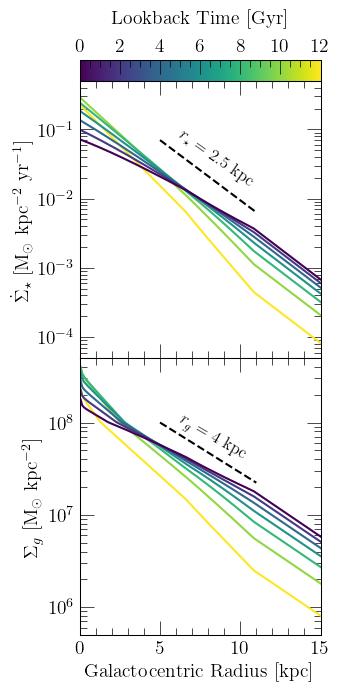

In [42]:
LOOKBACKS = [12, 10, 8, 6, 4, 2, 0]
COLORMAP = "viridis"

fig = plt.figure(figsize = (3.5, 7))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212, sharex = ax1)
for ax in [ax1, ax2]: ax.set_yscale("log")
ax1.set_xlim([0, 15])
ax2.set_xlabel(r"Galactocentric Radius [kpc]")
plt.setp(ax1.get_xticklabels(), visible = False)
ax1.set_ylabel(r"$\dot \Sigma_\star$ [M$_\odot$ kpc$^{-2}$ yr$^{-1}$]")
ax2.set_ylabel(r"$\Sigma_g$ [M$_\odot$ kpc$^{-2}$]")
ax1.set_ylim([5.e-5, 0.5])
ax2.set_ylim([5.e5, 5.e8])

norm = plt.Normalize(vmin = min(LOOKBACKS), vmax = max(LOOKBACKS))
cmap = plt.cm.ScalarMappable(cmap = COLORMAP, norm = norm)
cbar_ax = fig.add_axes([0.2, 0.8, 0.6, 0.05])
cbar = plt.colorbar(cmap, cax = cbar_ax, orientation = "horizontal", location = "top")
cbar.set_label("Lookback Time [Gyr]", labelpad = 10)
cbar.set_ticks(LOOKBACKS)

def plot_snapshot(ax_sfh, ax_gas, output, lookback, zone_width = 0.1, **kwargs):
    radii = [zone_width * (i + 0.5) for i in range(len(output.zones.keys()))]
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    sigma_sfr = []
    sigma_gas = []
    for i in range(len(radii)):
        area = np.pi * ((radii[i] + zone_width / 2)**2 - (radii[i] - zone_width / 2)**2)
        zone = output.zones["zone%d" % (i)]
        sigma_sfr.append(zone.history["sfr"][idx] / area)
        sigma_gas.append(zone.history["mgas"][idx] / area)
    ax_sfh.plot(radii, sigma_sfr, **kwargs)
    ax_gas.plot(radii, sigma_gas, **kwargs)

for i in range(len(LOOKBACKS)):
    kwargs = {"c": cmap.to_rgba(LOOKBACKS[i])}
    plot_snapshot(ax1, ax2, output, LOOKBACKS[i], **kwargs)

kwargs = {
    "c": named_colors()["black"],
    "linestyle": "--"
}
xvals = np.linspace(5, 11, 100)
yvals = [0.07 * np.exp(-(x - 5) / 2.5) for x in xvals]
ax1.plot(xvals, yvals, **kwargs)
yvals = [1.e8 * np.exp(-(x - 5) / 4) for x in xvals]
ax2.plot(xvals, yvals, **kwargs)
ax1.text(6, 0.015, r"$r_\star = 2.5$ kpc", fontsize = 12, rotation = -35)
ax2.text(6, 4e7, r"$r_g = 4$ kpc", fontsize = 12, rotation = -30)

plt.tight_layout()
plt.subplots_adjust(hspace = 0, top = 0.88)
cbar_ax.set_position([
    ax1.get_position().x0,
    ax1.get_position().y1,
    ax1.get_position().x1 - ax1.get_position().x0,
    0.03
])
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./evol/sfh-gas.%s" % (ext), **kwargs)
plt.show()

In [2]:
# outputs = [
#     "../outputs/river/insideout",
#     "../outputs/potential-well-deepening/gamma0p2",
#     "../outputs/angular-momentum-dilution/betaphiin0p7",
#     "../outputs/constant/vgas-0",
#     "../outputs/constant/vgas-0p5"
# ]
outputs = [
    "../outputs/constant/vgas-0",
    "../outputs/constant/vgas-0p5",
    "../outputs/constant/vgas-1",
    "../outputs/constant/vgas-1p5"
]
outputs = [vice.output(name) for name in outputs]

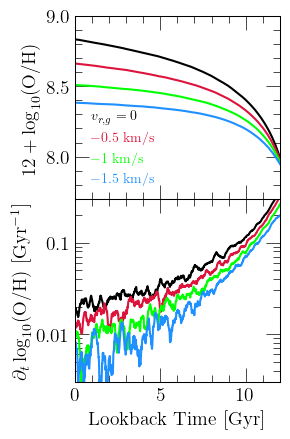

In [6]:
# COLORS = ["lime", "crimson", "dodgerblue", "black", "black"]
# LINESTYLES = [
#     ":", # River
#     "--", # PWD
#     "-.", # AMD
#     ":", # v = 0
#     "-", # v = -0.5 km/s
# ]
# LABELS = [
#     "River",
#     r"$\gamma = 0.2$",
#     r"$\beta_{\phi,\text{in}} = 0.7$",
#     r"$v_{r,g} = 0$",
#     r"$v_{r,g} = -0.5$ km/s"
# ]
COLORS = ["black", "crimson", "lime", "dodgerblue"]
# LINESTYLES = ["-", "-.", ":", "--"]
LINESTYLES = 4 * ["-"]
# LABELS = [r"$v_{r,g} = 0$", r"$v_{r,g} = -0.5$ km/s", r"$v_{r,g} = -1$ km/s", r"$v_{r,g} = -1.5$ km/s"]
LABELS = [r"$v_{r,g} = 0$", r"$-0.5$ km/s", r"$-1$ km/s", r"$-1.5$ km/s"]

fig = plt.figure(figsize = (3, 4.5))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212, sharex = ax1)
ax2.set_xlabel(r"Lookback Time [Gyr]")
ax1.set_ylabel(r"$12 + \log_{10}$(O/H)")
ax2.set_ylabel(r"$\partial_t \log_{10}$(O/H) [Gyr$^{-1}$]")
plt.setp(ax1.get_xticklabels(), visible = False)
ax1.set_ylim([7.7, 9.])
ax1.set_xlim([0, 12])
ax2.set_ylim([0.003, 0.3])
ax2.set_yscale("log")
ax2.yaxis.set_major_formatter(fsf("%g"))

def plot_time_enrichment(output, radius, zone_width = 0.1, **kwargs):
    zone = int(radius / zone_width)
    zone = output.zones["zone%d" % (zone)]
    lookback = zone.history["lookback"]
    oh = oh_to_12pluslog(zone.history["[o/h]"])
    ax1.plot(lookback, oh, **kwargs)
    dt = zone.history["time"][1] - zone.history["time"][0]
    dohdt = [(a - b) / dt for a, b in zip(oh[1:], oh[:-1])]
    dohdt = boxcarsmoothtrend(lookback[:-1], dohdt, window = 10)
    ax2.plot(lookback[:-1], dohdt, **kwargs)

for i in range(len(outputs)):
    kwargs = {
        "c": named_colors()[COLORS[i]],
        "linestyle": LINESTYLES[i],
        "label": LABELS[i]
    }
    plot_time_enrichment(outputs[i], 8, **kwargs)

kwargs = {
    "loc": mpl_loc("lower left"),
    "ncol": 1,
    "handlelength": 0,
    "fontsize": 10,
    "columnspacing": 0.5
}
leg = ax1.legend(**kwargs)
fancy_legend(leg, COLORS)

plt.tight_layout()
plt.subplots_adjust(hspace = 0)
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./evol/oh-timeevol-rsun.%s" % (ext), **kwargs)
plt.show()

In [2]:
outputs = [
#     "../outputs/constant/vgas-0",
#     "../outputs/linear/dvdr-0p02",
    # "../outputs/potential-well-deepening/gamma0p1",
    # "../outputs/potential-well-deepening/gamma0p2",
    # "../outputs/potential-well-deepening/gamma0p3"
    # "../outputs/amd/betaphiin0p8",
    # "../outputs/amd/betaphiin0p7",
    # "../outputs/amd/betaphiin0p6"
#     "../outputs/river/insideout"
    "../outputs/potential-well-deepening/gamma0p1",
    "../outputs/constant/vgas-1",
    "../outputs/angular-momentum-dilution/betaphiin0p6"
]
outputs = [vice.output(name) for name in outputs]

/Users/jamesjohnson/Work/Research/lib/personal/plots/mpltoolkit/core.py:103: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels)
/var/folders/26/nqb98q9x5_q6brmqy4v21dqm0000gp/T/ipykernel_58539/2412998826.py:109: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


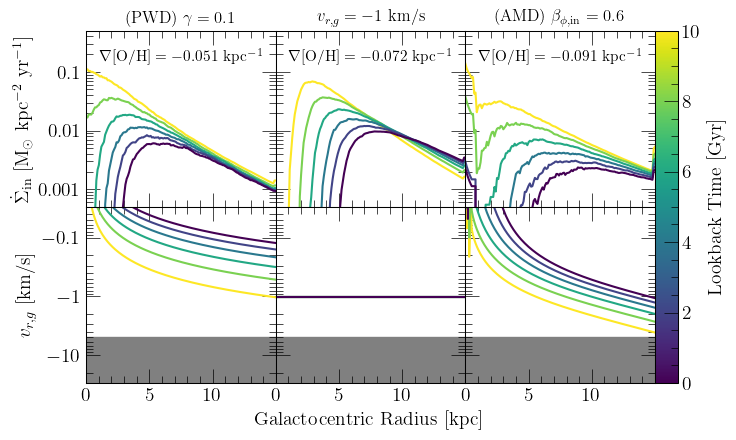

In [8]:
# LOOKBACKS = range(0, 13, 2)[::-1]
LOOKBACKS = [0, 2, 4, 6, 8, 10][::-1]
COLORMAP = "viridis"
TITLES = [
#     r"$\frac{\partial v_{r,g}}{\partial R} = -0.02$ Gyr$^{-1}$",
#     r"$\frac{\partial v_{r,g}}{\partial R} = -0.05$ Gyr$^{-1}$",
#     r"$\partial v_{r,g} / \partial R = -0.02$ Gyr$^{-1}$",
    # r"(PWD) $\gamma = 0.1$",
    # r"(PWD) $\gamma = 0.2$",
    # r"(PWD) $\gamma = 0.3$"
    # r"(AMD) $\beta_{\phi,\text{in}} = 0.7$",
    # r"(AMD) $\beta_{\phi,\text{in}} = 0.5$"
    # r"(AMD) $\beta_{\phi,\text{in}} = 0.8$",
    # r"(AMD) $\beta_{\phi,\text{in}} = 0.7$",
    # r"(AMD) $\beta_{\phi,\text{in}} = 0.6$"
    r"(PWD) $\gamma = 0.1$",
    r"$v_{r,g} = -1$ km/s",
    r"(AMD) $\beta_{\phi,\text{in}} = 0.6$"
]
# GRADSLOPES = [-0.06, -0.12, -0.15]
GRADSLOPES = [-0.051, -0.072, -0.091]
KPCPERGYR_TO_KMS = 1.022

fig = plt.figure(figsize = (7.5, 4.5))
top = []
bottom = []
for i in range(3):
    kwargs = {}
    if i:
        kwargs["sharex"] = top[0]
        kwargs["sharey"] = top[0]
    else: pass
    top.append(fig.add_subplot(231 + i, **kwargs))
    plt.setp(top[i].get_xticklabels(), visible = False)
#     top[i].text(2, 0.2, TITLES[i], fontsize = 12)
    # top[i].text(3, 0.15, r"$\nabla_\text{eq} = %g$ kpc$^{-1}$" % (GRADSLOPES[i]), fontsize = 12)
    top[i].text(1, 0.15, r"$\nabla\text{[O/H]} = %g$ kpc$^{-1}$" % (GRADSLOPES[i]), fontsize = 11)
    top[i].set_title(TITLES[i], fontsize = 12)
    kwargs["sharex"] = top[0]
    if i:
        kwargs["sharey"] = bottom[0]
    else:
        kwargs["sharey"] = None
    bottom.append(fig.add_subplot(234 + i, **kwargs))
    if i:
        plt.setp(top[i].get_yticklabels(), visible = False)
        plt.setp(bottom[i].get_yticklabels(), visible = False)
    else: pass
bottom[1].set_xlabel(r"Galactocentric Radius [kpc]")
top[0].set_ylabel(r"$\dot \Sigma_\text{in}$ [M$_\odot$ kpc$^{-2}$ yr$^{-1}$]")
bottom[0].set_ylabel(r"$v_{r,g}$ [km/s]")
top[0].set_yscale("log")
top[0].set_xlim([0, 15])
top[0].set_xticks([0, 5, 10])
top[0].set_ylim([5.e-4, 5.e-1])
top[0].yaxis.set_major_formatter(fsf("%g"))
bottom[0].set_yscale("log")
bottom[0].set_ylim([0.03, 30])
bottom[0].set_yticks([0.1, 1, 10])
bottom[0].yaxis.set_major_formatter(fsf("%g"))


norm = plt.Normalize(vmin = min(LOOKBACKS), vmax = max(LOOKBACKS))
cmap = plt.cm.ScalarMappable(cmap = COLORMAP, norm = norm)
cbar_ax = fig.add_axes([0.9, 0.1, 0.05, 0.6])
cbar = plt.colorbar(cmap, cax = cbar_ax, orientation = "vertical")
cbar.set_label("Lookback Time [Gyr]")
# cbar.ax.xaxis.set_ticks_position("top")
# cbar.ax.xaxis.set_label_position("top")
cbar.set_ticks([0, 2, 4, 6, 8, 10])

def plot_predictions(ax_ifr, ax_v, output, lookback, zone_width = 0.1, **kwargs):
    if os.path.exists("%s_gasvelocities.out" % (output.name)):
        radii, vgas = get_velocity_profile(output, lookback)
    else:
        radii = [zone_width * (i + 0.5) for i in range(int(20 / zone_width))]
        vgas = len(radii) * [0.]
    vgas = [KPCPERGYR_TO_KMS * v for v in vgas]
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    sigma_in = []
    for i in range(len(radii)):
        zone = output.zones["zone%d" % (i)]
        area = np.pi * ((radii[i] + zone_width)**2 - radii[i]**2)
        sigma_in.append(zone.history["ifr"][idx] / area)
    radii = radii[:155]
    sigma_in = sigma_in[:155]
    sigma_in = boxcarsmoothtrend(radii, sigma_in, window = 5)
    # if lookback == 0: print(sigma_in)
    ax_ifr.plot(radii, sigma_in, **kwargs)
    ax_v.plot(radii, [-v for v in vgas][:len(radii)], **kwargs)
    
for i in range(len(outputs)):
# for i in [0]:
    for j in range(len(LOOKBACKS)):
        kwargs = {
            "c": cmap.to_rgba(LOOKBACKS[j])
        }
        plot_predictions(top[i], bottom[i], outputs[i], LOOKBACKS[j], **kwargs)
    bottom[i].fill_between(bottom[i].get_xlim(), 2 * [5], 2 * bottom[i].get_ylim()[1],
        color = named_colors()["grey"])

# for i in range(len(bottom)):
#     bottom[i].set_yscale("log")
#     bottom[i].set_ylim([0.05, 50])
# #     bottom[i].yaxis.set_major_formatter(fsf("%g"))
#     negative_log(bottom[i])
negative_log(bottom[0])
plt.tight_layout()
plt.subplots_adjust(hspace = 0, wspace = 0, right = 0.88)
cbar_ax.set_position([
    bottom[-1].get_position().x1,
    bottom[-1].get_position().y0,
    0.03,
    top[-1].get_position().y1 - bottom[-1].get_position().y0
])
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./evol/sigmaifr_vgas_profiles.%s" % (ext), **kwargs)
plt.show()

In [2]:
def equilibrium_profile(output, lookback, N = 1.5, zone_width = 0.1):
    if os.path.exists("%s_gasvelocities.out" % (output.name)):
        radii, mu_g, mu_o = mu(output, lookback, zone_width = zone_width)
    else:
        radii = [zone_width * i for i in range(len(output.zones.keys()))]
        mu_g = mu_o = len(radii) * [0.]
    radii = [r + zone_width / 2 for r in radii]
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    zeq = []
    for i in range(len(radii) - 1):
        zone = output.zones["zone%d" % (i)]
        if zone.history["sfr"][idx]:
            taustar = zone.history["mgas"][idx] / zone.history["sfr"][idx] * 1.e-9
            eta = zone.history["ofr"][idx] / zone.history["sfr"][idx]
        else:
            taustar = float("inf")
            eta = 0
        recycling = zone.history["r_eff"][idx]
        if idx == len(zone.history["time"]) - 1: idx -= 1
        dt = zone.history["time"][idx + 1] - zone.history["time"][idx]
        # dlnmgdt = zone.history["mgas"][idx + 1] - zone.history["mgas"][idx]
        # dlnmgdt /= dt * zone.history["mgas"][idx]
        # zeq.append(zone.ccsne_yields["o"] / (1 + eta - mu_o[i] - recycling + taustar * dlnmgdt))
        sfh = insideout(radii[i])
        tausfh = sfh.timescale
        zeq.append(zone.ccsne_yields["o"] / (1 + eta - mu_o[i] - recycling - taustar / (N * tausfh)))
    return [radii, zeq]

In [3]:
outputs = [
    "../outputs/constant/vgas-0p5",
    "../outputs/potential-well-deepening/gamma0p2",
    "../outputs/angular-momentum-dilution/betaphiin0p7",
    "../outputs/river/insideout"
]
outputs = [vice.output(name) for name in outputs]

/var/folders/26/nqb98q9x5_q6brmqy4v21dqm0000gp/T/ipykernel_23819/1740780471.py:46: RuntimeWarning: invalid value encountered in log10
  zeq = [np.log10(z / vice.solar_z['o']) for z in zeq]
/Users/jamesjohnson/Work/Research/milkyway/radial-flows/notebooks/../src/utils.py:99: RuntimeWarning: divide by zero encountered in scalar divide
  mu += (vgas[i + 1] - vgas[i]) / (vgas[i] * zone_width)
/Users/jamesjohnson/Work/Research/milkyway/radial-flows/notebooks/../src/utils.py:100: RuntimeWarning: invalid value encountered in scalar multiply
  mu *= -tau_star * vgas[i]
/var/folders/26/nqb98q9x5_q6brmqy4v21dqm0000gp/T/ipykernel_23819/1740780471.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


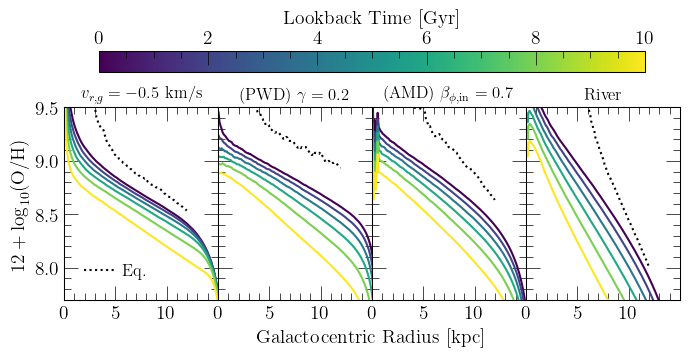

In [4]:
LOOKBACKS = [0, 2, 4, 6, 8, 10]
COLORMAP = "viridis"
TITLES = [
    r"$v_{r,g} = -0.5$ km/s",
    r"(PWD) $\gamma = 0.2$",
    r"(AMD) $\beta_{\phi,\text{in}} = 0.7$",
    r"River"
]
GRAD = [-0.0717, -0.0564, -0.0934, -0.174]

fig = plt.figure(figsize = (7, 3.5))
axes = []
for i in range(4):
    kwargs = {}
    if i:
        kwargs["sharex"] = axes[0]
        kwargs["sharey"] = axes[0]
    else: pass
    axes.append(fig.add_subplot(141 + i, **kwargs))
    if i: plt.setp(axes[i].get_yticklabels(), visible = False)
    axes[i].set_title(TITLES[i], fontsize = 12)
dummy = fig.add_axes([0.1, 0.1, 0.8, 0.8], xticks = [], yticks = [], zorder = -1000)
dummy.set_xlabel(r"Galactocentric Radius [kpc]", labelpad = 20)
axes[0].set_ylabel(r"$12 + \log_{10}$(O/H)")
axes[0].set_xlim([0, 15])
axes[0].set_xticks([0, 5, 10])
axes[0].set_ylim([7.7, 9.5])

norm = plt.Normalize(vmin = min(LOOKBACKS), vmax = max(LOOKBACKS))
cmap = plt.cm.ScalarMappable(cmap = COLORMAP, norm = norm)
cbar_ax = fig.add_axes([0.1, 0.8, 0.8, 0.1])
cbar = plt.colorbar(cmap, cax = cbar_ax, orientation = "horizontal", location = "top")
cbar.set_label(r"Lookback Time [Gyr]")

def plot_snapshot(ax, output, lookback, zone_width = 0.1, **kwargs):
    radii = [zone_width * (i + 0.5) for i in range(len(output.zones.keys()))]
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    oh = []
    for i in range(len(radii)):
        oh.append(output.zones["zone%d" % (i)].history["[o/h]"][idx])
    oh = oh_to_12pluslog(oh)
    ax.plot(radii, oh, **kwargs)
    if lookback == 0:
        radii, zeq = equilibrium_profile(output, lookback, zone_width = 0.1)
        zeq = [np.log10(z / vice.solar_z['o']) for z in zeq]
        zeq = oh_to_12pluslog(zeq)
        zeq = boxcarsmoothtrend(radii[:-1], zeq, window = 5)
        ax.plot(radii[30:120], zeq[30:120], c = named_colors()["black"], linestyle = ":", label = "Eq.")
    else: pass

for i in range(len(outputs)):
    for j in range(len(LOOKBACKS)):
        kwargs = {"c": cmap.to_rgba(LOOKBACKS[j])}
        plot_snapshot(axes[i], outputs[i], LOOKBACKS[j], **kwargs)

kwargs = {
    "loc": mpl_loc("lower left"),
    "fontsize": 12,
    "bbox_to_anchor": (0.03, 0.03)
}
axes[0].legend(**kwargs)

# xvals = np.linspace(5, 10, 100)
kwargs = {
    "c": named_colors()["black"],
    "linestyle": ":"
}
# for i in range(4):
    # yvals = [9.2 + GRAD[i] * (x - xvals[0]) for x in xvals]
    # axes[i].plot(xvals, yvals, **kwargs)
    # angle = np.arctan(GRAD[i]) * 180 / np.pi
    # axes[i].text(6, 9.2, r"$%.3f$ kpc$^{-1}$" % (GRAD[i]), fontsize = 11,
    #     rotation = angle, rotation_mode = "anchor", transform_rotates_text = True)

plt.tight_layout()
plt.subplots_adjust(wspace = 0, top = 0.7, bottom = 0.15)
dummy.set_position([
    axes[0].get_position().x0,
    axes[0].get_position().y0,
    axes[-1].get_position().x1 - axes[0].get_position().x0,
    axes[0].get_position().y1 - axes[0].get_position().y0
])
cbar_ax.set_position([
    axes[0].get_position().x0 + 0.05,
    axes[0].get_position().y1 + 0.1,
    axes[-1].get_position().x1 - axes[0].get_position().x0 - 0.1,
    0.06
])
# for ext in ["pdf", "jpeg"]:
#     kwargs = {}
#     if ext == "jpeg": kwargs["dpi"] = 200
#     plt.savefig("./evol/profile-evol-comp.%s" % (ext), **kwargs)
plt.show()

In [49]:
# output = vice.output("../outputs/constant/vgas-1")
# output = vice.output("../outputs/amd/betaphiin0p7-zerometinfall")
# output = vice.output("../outputs/river/insideout-zerometinfall")
output = vice.output("../outputs/potential_well_deepening/gamma0p2-xhcgm-0p7")

/var/folders/mh/jf6nfbl941l_41vvvwwk5wbr0000gn/T/ipykernel_86731/365361750.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


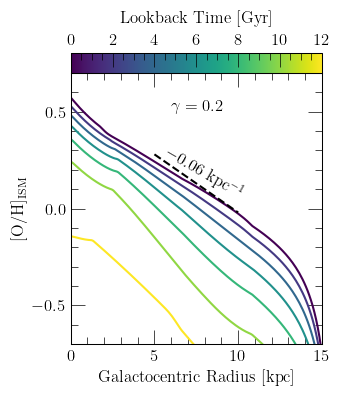

In [50]:
LOOKBACKS = [12, 10, 8, 6, 4, 2, 0]
COLORMAP = "viridis"
REFSLOPE = -0.06
REFOFFSET = 0.1
REFTEXT_X = 5.5
REFTEXT_Y = 0.05
REFTEXT_ROT = -30

fig = plt.figure(figsize = (3.5, 4))
ax = fig.add_subplot(111)
ax.set_xlabel(r"Galactocentric Radius [kpc]")
ax.set_ylabel(r"[O/H]$_\text{ISM}$")
ax.set_xlim([0, 15])
ax.set_ylim([-0.7, 0.7])
ax.set_yticks([-0.5, 0, 0.5])

### ANNOTATION IN THE UPPER RIGHT
# ax.text(6, 0.5, r"$v_{r,g} = -1$ km/s", fontsize = 12)
# ax.text(6, 0.5, r"$\beta_{\phi,\text{in}} = 0.7$", fontsize = 12)
# ax.text(6, 0.5, r"River", fontsize = 12)
ax.text(6, 0.5, r"$\gamma = 0.2$", fontsize = 12)

norm = plt.Normalize(vmin = min(LOOKBACKS), vmax = max(LOOKBACKS))
cmap = plt.cm.ScalarMappable(cmap = COLORMAP, norm = norm)
cbar_ax = fig.add_axes([0.9, 0.1, 0.05, 0.6])
cbar = plt.colorbar(cmap, cax = cbar_ax, orientation = "horizontal")
cbar.set_label("Lookback Time [Gyr]", labelpad = 8)
cbar.ax.xaxis.set_ticks_position("top")
cbar.ax.xaxis.set_label_position("top")
cbar.set_ticks([0, 2, 4, 6, 8, 10, 12])

def plot_snapshot(output, lookback, zone_width = 0.1, **kwargs):
    radii = [zone_width * (i + 0.5) for i in range(len(output.zones.keys()))]
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    oh = []
    for i in range(len(radii)):
        oh.append(output.zones["zone%d" % (i)].history["[o/h]"][idx])
    ax.plot(radii, oh, **kwargs)
    
for i in range(len(LOOKBACKS)):
    kwargs = {
        "c": cmap.to_rgba(LOOKBACKS[i])
    }
    plot_snapshot(output, LOOKBACKS[i], **kwargs)
    
xvals = np.linspace(5, 10, 100)
yvals = [REFSLOPE * (r - 8) + REFOFFSET for r in xvals]
ax.plot(xvals, yvals, c = named_colors()["black"], linestyle = "--")
ax.text(REFTEXT_X, REFTEXT_Y, r"$%.2f$ kpc$^{-1}$" % (REFSLOPE), fontsize = 12, rotation = REFTEXT_ROT)

plt.tight_layout()
plt.subplots_adjust(top = 0.82)
cbar_ax.set_position([
    ax.get_position().x0,
    ax.get_position().y1,
    ax.get_position().x1 - ax.get_position().x0,
    0.05
])
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
#     plt.savefig("./evol/oh-ism-snapshots-%s.%s" % (output.name.split('/')[-1], ext), **kwargs)
#     plt.savefig("./evol/oh-ism-snapshots-river.%s" % (ext), **kwargs)
    # plt.savefig("./evol/oh-ism-snapshots-pwd.%s" % (ext), **kwargs)
plt.show()

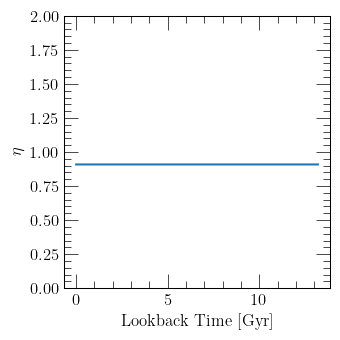

In [34]:
fig = plt.figure(figsize = (3.5, 3.5))
ax = fig.add_subplot(111)
ax.set_xlabel(r"Lookback Time [Gyr]")
ax.set_ylabel(r"$\eta$")
ax.set_ylim([0, 2])

zone = 80
zone = output.zones["zone%d" % (zone)]
eta = [o / s if s else float("inf") for o, s in zip(zone.history["ofr"], zone.history["sfr"])]
ax.plot(zone.history["lookback"], eta)

plt.tight_layout()
plt.show()

In [19]:
# outputs = [
#     "../outputs/constant/vgas-0",
#     "../outputs/constant/vgas-0p5",
#     "../outputs/constant/vgas-1",
#     "../outputs/constant/vgas-1p5",
# ]
# outputs = [
#     "../outputs/constant/vgas-0",
#     "../outputs/amd/betaphiin0p7",
#     "../outputs/amd/betaphiin0p5",
# ]
# outputs = [
#     "../outputs/constant/vgas-0",
#     "../outputs/river/insideout"
# ]
outputs = [
    "../outputs/constant/vgas-0",
    "../outputs/potential_well_deepening/gamma0p1",
    "../outputs/potential_well_deepening/gamma0p2",
    "../outputs/potential_well_deepening/gamma0p2-rc25const"
]
outputs = [vice.output(name) for name in outputs]

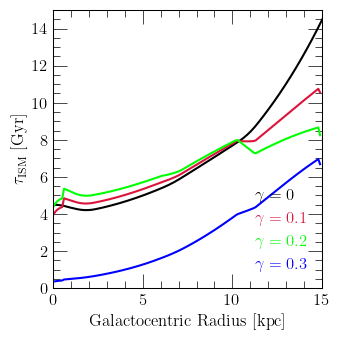

In [21]:
COLORS = ["black", "crimson", "lime", "blue"]
LABELS = [r"$\gamma = %g$" % (g / 10) for g in range(4)]
# LABELS = [r"$0$ km/s", r"$-0.5$ km/s", r"$-1$ km/s", r"$-1.5$ km/s"]
# COLORS = ["black", "crimson", "blue"]
# LABELS = [
#     r"$\beta_{\phi,\text{in}} = 1$",
#     r"$\beta_{\phi,\text{in}} = 0.7$",
#     r"$\beta_{\phi,\text{in}} = 0.5$"
# ]
# COLORS = ["black", "crimson"]
# LABELS = [r"$v_{r,g} = 0$", "River"]
IMAGE_NAME_ENDING = "river"

fig = plt.figure(figsize = (3.5, 3.5))
ax = fig.add_subplot(111)
ax.set_xlabel(r"Galactocentric Radius [kpc]")
ax.set_ylabel(r"$\tau_\text{ISM}$ [Gyr]")
ax.set_xlim([0, 15])
# ax.set_ylim([0, 10])
ax.set_ylim([0, 15])
# ax.set_yticks([0, 5, 10, 15])
# ax.set_ylim([-50, 10])

def tau_ism_profile(output, gasflows = True, zone_width = 0.1):
    if gasflows:
        radii, mu_g, _ = mu(output, 0, zone_width = zone_width)
    else:
        radii = [zone_width * (i + 0.5) for i in range(int(20 / zone_width))]
        mu_g = len(radii) * [0.]
    tau_ism = []
    for i in range(len(radii) - 1):
        zone = output.zones["zone%d" % (i)]
        if zone.history["sfr"][-1]:
            tau_star = zone.history["mgas"][-1] / zone.history["sfr"][-1] * 1.e-9
            eta = zone.history["ofr"][-1] / zone.history["sfr"][-1]
        else:
            tau_star = float("inf")
            eta = 0
        try:
            tau_star = zone.history["mgas"][-1] / zone.history["sfr"][-1] * 1.e-9
        except ZeroDivisionError:
            tau_star = float("inf")
        recycling = zone.history["R_eff"][-1]
        try:
            tau_ism.append(tau_star / (1 + eta - mu_g[i] - recycling))
        except ZeroDivisionError:
            tau_ism.append(float("inf"))
#         if tau_ism[-1] < 0: tau_ism[-1] = float("nan")
    # print(tau_ism)
    return [radii[:-1], tau_ism]

def plot_model(output, gasflows = True, zone_width = 0.1, **kwargs):
    radii, tau_ism = tau_ism_profile(output, gasflows = gasflows, zone_width = zone_width)
    if m.isnan(tau_ism[0]): tau_ism[0] = 0
    tau_ism = boxcarsmoothtrend(radii, tau_ism, window = 5)
    # tau_ism = boxcarsmooth(radii, tau_ism, window = 10)
    ax.plot(radii, tau_ism, **kwargs)
    
for i in range(len(outputs)):
    kwargs = {
        "c": named_colors()[COLORS[i]],
        "label": LABELS[i]
    }
    plot_model(outputs[i],
        gasflows = os.path.exists("%s_gasvelocities.out" % (outputs[i].name)),
        **kwargs)
    
kwargs = {
#     "loc": mpl_loc("lower left"),
    "loc": mpl_loc("lower right"),
    "handlelength": 0,
#     "ncol": 2,
#     "columnspacing": 0.5
}
leg = ax.legend(**kwargs)
fancy_legend(leg, COLORS)

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    # plt.savefig("./evol/tau-ism-%s.%s" % (IMAGE_NAME_ENDING, ext), **kwargs)
plt.show()